In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio import Phylo
import numpy as np


In [2]:
##### load in data and the handling steps #####
# info = pd.read_csv('samples_genus_familiy.csv', sep=';')
# species={}
# for _, row in info.iterrows():
#     if row.FOLDER not in species:
#         name = row.GENUS + '_' + row.SPECIES +'_ssp'
#         species[name]=row.family
#     else:
#         continue
# dataframes = [f'/faststorage/project/primatediversity/data/gVCFs_recalling_10_12_2024/{specie}/stats/HET/{specie}_het_stats.csv' for specie in species.keys()]
# df_list = []
# for i in dataframes:
#     try:
#         df_list.append(pd.read_csv(i, sep=','))
#     except Exception:
#         continue
# df = pd.concat(df_list)
# df = df.merge(info,left_on=['Species'],right_on=['FOLDER'])[['Sample','BIOSAMPLE_ID','Chromosome','Species','Chrom_Type','Genetic_sex','Het_Count','Callable_Length','Het_per_bp','family']]
# callable_len = df.groupby(['Sample','BIOSAMPLE_ID','Species','Chrom_Type','Genetic_sex','family'])['Callable_Length'].sum().reset_index()
# count = df.groupby(['Sample','BIOSAMPLE_ID','Species','Chrom_Type','Genetic_sex','family'])['Het_Count'].sum().reset_index()
# summary = count.merge(callable_len, on =['Sample','BIOSAMPLE_ID','Species','family','Chrom_Type','Genetic_sex'])
# summary = summary.sort_values('Species')
# summary['Genus'] = summary['Species'].str.split('_').str[0]
# summary['Het_per_bp']=summary['Het_Count']/summary['Callable_Length']
# summary = summary.loc[summary['Sample'] != 'PD_0294']
# summary = summary.sort_values(by=['family','Species'])
# summary.to_csv('figure2_summary.csv')
# summary_pivot = summary.pivot_table(
#     index=['Sample', 'Species', 'Genus', 'family'], 
#     columns='Chrom_Type', 
#     values='Het_per_bp'
# ).reset_index()
# summary_pivot['XA_ratio']=summary_pivot['X']/summary_pivot['A']
# summary_pivot = summary_pivot[['Sample','Genus','Species','family','XA_ratio']].dropna()
# summary_pivot.to_csv('figure2_xa_ratio.csv')


In [5]:
summary_pivot = pd.read_csv('figure2_xa_ratio.csv')
summary = pd.read_csv('figure2_summary.csv')

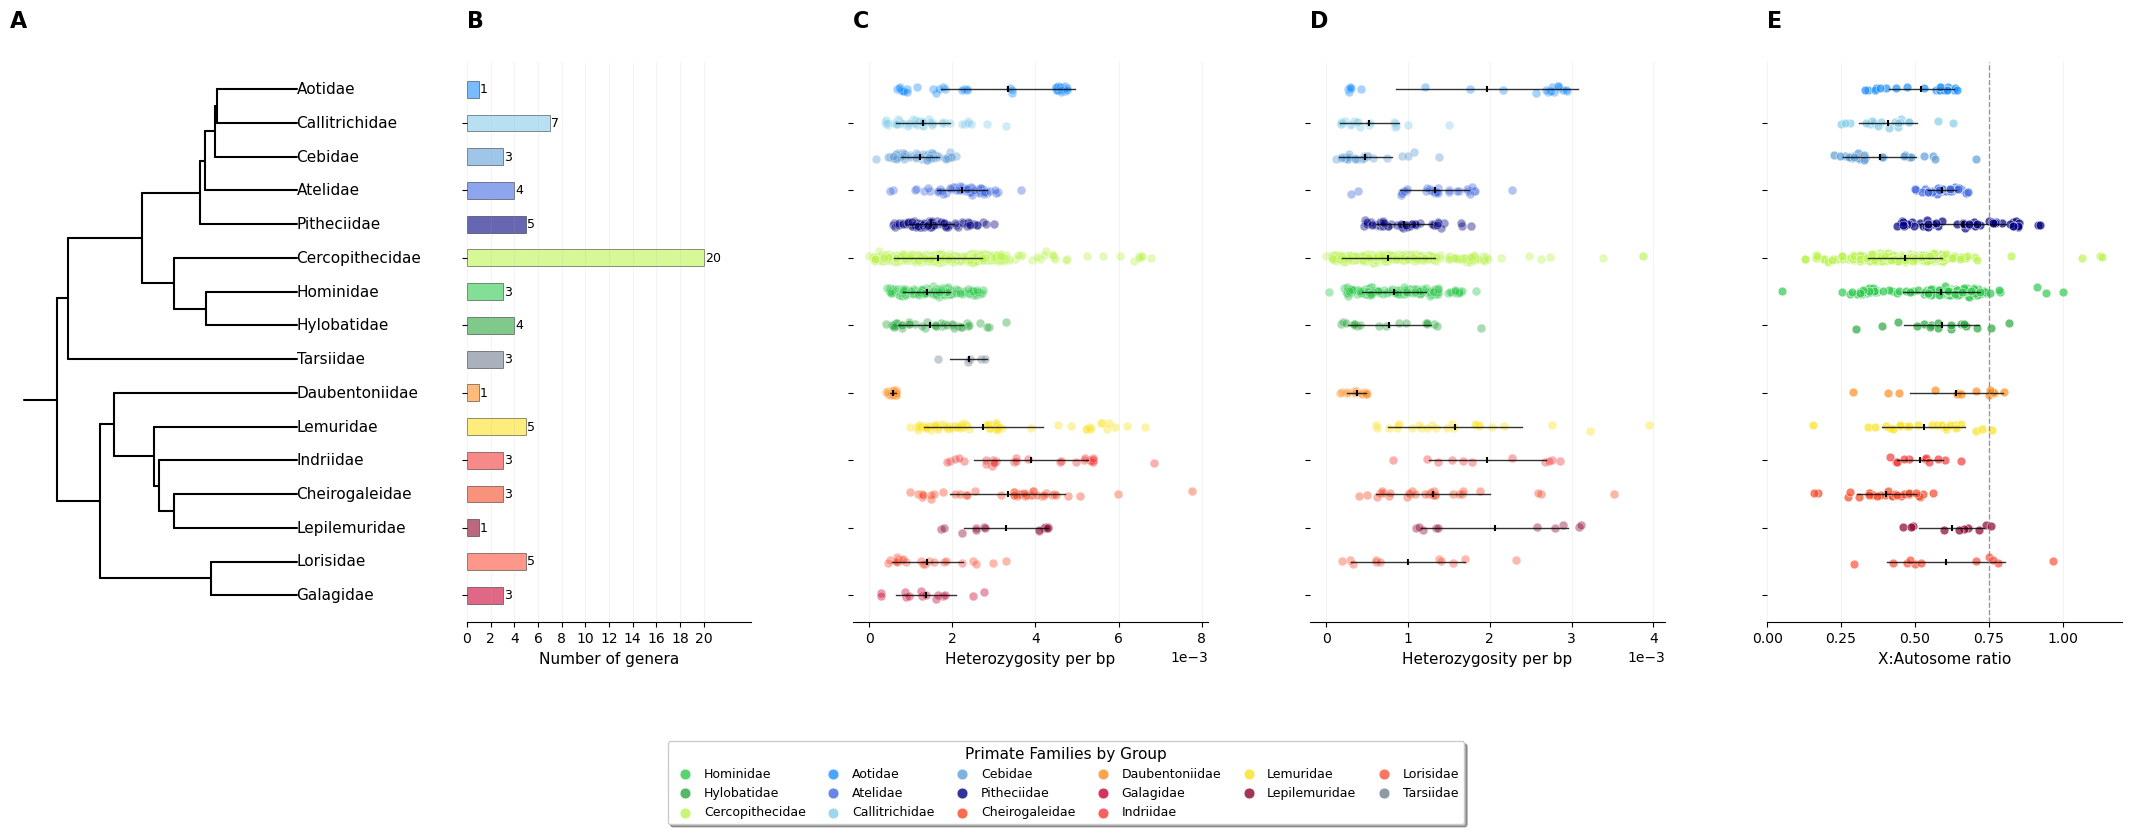

In [6]:
# Set publication-ready style
plt.style.use('default')
sns.set_palette("husl")

# Read tree
tree = Phylo.read("kuderna_newick.tree", "newick")

# Get unique genera and families from your data
genera_in_data = list(summary['Genus'].unique())
families_in_data = list(summary['family'].unique())

# Create genus to family mapping
genus_family_map = {}
for _, row in summary.iterrows():
    if row.Genus not in genus_family_map:
        genus_family_map[row.Genus] = row.family

# Find one representative species per family
family_representatives = {}  # Track which families already have a representative
species_to_keep = []
excluded_genera = ['Tupaia', 'Galeopterus', 'Callibella', 'Homo', 'Mus', 'Oryctolagus']

for terminal in tree.get_terminals():
    # Extract genus from species name (assuming format: Genus_species)
    genus = terminal.name.split('_')[0]
    
    # Check if this genus is in our data and has a family mapping
    if genus in genera_in_data and genus in genus_family_map:
        family_name = genus_family_map[genus]
        
        if family_name not in family_representatives:
            family_representatives[family_name] = terminal.name
            species_to_keep.append(terminal.name)

# Create a copy of the tree and prune it
pruned_tree = Phylo.read("kuderna_newick.tree", "newick")

# Get terminals to remove (those not in our keep list)
terminals_to_remove = [t for t in pruned_tree.get_terminals()
                       if t.name not in species_to_keep]

# Prune the tree
for terminal in terminals_to_remove:
    pruned_tree.prune(terminal)

# Rename terminals to family names
for terminal in pruned_tree.get_terminals():
    genus = terminal.name.split('_')[0]
    if genus in genus_family_map:
        family_name = genus_family_map[genus]
        terminal.name = family_name

# Create figure with 5 panels 
fig = plt.figure(figsize=(24, 8))
gs = fig.add_gridspec(1, 5, width_ratios=[1, 0.8, 1, 1, 1], wspace=0.3, hspace=0.1,
                     left=0.06, right=0.94, top=0.88, bottom=0.18)

ax1 = fig.add_subplot(gs[0])  # Tree
ax_genus = fig.add_subplot(gs[1])  # Genus count panel
ax2 = fig.add_subplot(gs[2])  # Autosomes
ax3 = fig.add_subplot(gs[3])  # X chromosome
ax4 = fig.add_subplot(gs[4])  # X:A ratio

# Draw the phylogenetic tree with cleaner styling
Phylo.draw(pruned_tree, axes=ax1, do_show=False)
ax1.set_title('A', fontsize=16, fontweight='bold', loc='left', pad=25)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])
ax1.set_yticks([])

# Extract terminal positions for families and clean up labels
terminal_positions = {}
family_order = []

for text_obj in ax1.texts:
    txt = text_obj.get_text().strip()
    
    # Check if this is a family name or excluded genus
    if txt in families_in_data:
        x, y = text_obj.get_position()
        
        if txt not in terminal_positions:
            terminal_positions[txt] = y
            family_order.append(txt)
            # Format family names
            text_obj.set_fontsize(11)
            if txt not in excluded_genera:
                text_obj.set_text(txt.replace('_', ' '))  # Clean up family names

# Get data for both chromosome types
x_chrom_data = summary[summary['Chrom_Type'] == 'X'].copy()
a_chrom_data = summary[summary['Chrom_Type'] == 'A'].copy()

# Calculate X:A ratios
xa_ratio_df = summary_pivot 

# MANUAL COLOR MAPPING - Replace these hex codes with your preferred colors
family_colors = {
    # Apes 
    'Hominidae': '#31C950',      
    'Hylobatidae': '#2AA63E',    
    
    # Old World monkeys 
    'Cercopithecidae': '#BBF451', 
    
    # New World monkeys 
    'Aotidae': '#1E90FF',        
    'Atelidae': '#4169E1',        
    'Callitrichidae': '#87CEEB',  
    'Cebidae': '#5F9FD8',         
    'Pitheciidae': '#000080',    
    
    # Prosimians
    'Daubentoniidae': '#FE8E22',  
    'Galagidae': '#C90434',       
    'Indriidae': '#F33A3A',       
    'Lemuridae': '#FCE222',       
    'Lepilemuridae': '#8B032C',   
    'Cheirogaleidae': '#F54927',
    'Lorisidae': '#FC523B',       
    
    # Tarsiidae 
    'Tarsiidae': '#708090',     
}

# For the legend grouping
family_groups = {
    'Aotidae': 'New World monkey',
    'Hylobatidae': 'Ape',
    'Atelidae': 'New World monkey',
    'Callitrichidae':'New World monkey',
    'Cebidae':'New World monkey',
    'Cercopithecidae':'Old World monkey',
    'Cheirogaleidae':'Prosimian',
    'Daubentoniidae': 'Prosimian',
    'Galagidae':'Prosimian',
    'Hominidae': 'Ape',
    'Indriidae':'Prosimian',
    'Lemuridae': 'Prosimian',
    'Lepilemuridae':'Prosimian',
    'Lorisidae':'Prosimian',
    'Pitheciidae':'New World monkey',
    'Tarsiidae':'Tarsiidae',
}

# Group families for legend
grouped_families = {}
for family, group in family_groups.items():
    if group not in grouped_families:
        grouped_families[group] = []
    grouped_families[group].append(family)

# Normalize positions if needed
y_min, y_max = ax1.get_ylim()
pos_values = list(terminal_positions.values())

if len(set(pos_values)) == 1:
    n_families = len(terminal_positions)
    y_positions_normalized = np.linspace(y_min + 0.5, y_max - 0.5, n_families)
    for i, family in enumerate(terminal_positions.keys()):
        terminal_positions[family] = y_positions_normalized[i]

# Plot genus count panel
def plot_genus_counts(ax):
    """Plot the number of genera per family"""
    genus_counts = []
    family_names_for_counts = []
    
    for family in family_order:
        if family in terminal_positions:
            if family in excluded_genera:
                # Skip excluded genera in the count
                continue
            else:
                # Count unique genera in this family
                family_genera = summary[summary['family'] == family]['Genus'].nunique()
                if family_genera > 0:
                    genus_counts.append(family_genera)
                    family_names_for_counts.append(family)
                    
                    # Plot bar
                    base_y = terminal_positions[family]
                    ax.barh(base_y, family_genera, height=0.5, 
                           color=family_colors.get(family, '#808080'), alpha=0.6,
                           edgecolor='black', linewidth=0.5)
                    
                    # Add count text
                    ax.text(family_genera + 0.1, base_y, str(family_genera),
                           va='center', fontsize=9)
    
    # Format axis
    ax.set_ylim(ax1.get_ylim())
    ax.set_xlabel('Number of genera', fontsize=11)
    ax.set_title('B', fontsize=16, fontweight='bold', loc='left', pad=25)
    ax.set_xlim(0, max(genus_counts) * 1.2 if genus_counts else 10)
    ax.grid(True, axis='x', alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Add x-axis ticks
    ax.set_xticks(range(0, int(max(genus_counts) + 1) if genus_counts else 10, 2))

# Function to plot chromosome data with improved styling
def plot_chromosome_data(ax, chrom_data, title, panel_label):
    family_means = []
    family_stds = []
    family_names = []
    
    for family in family_order:
        if family in terminal_positions:
            family_data = chrom_data[chrom_data['family'] == family]
            if len(family_data) > 0:
                base_y = terminal_positions[family]
                
                # Calculate mean and std for error bars
                mean_het = family_data['Het_per_bp'].mean()
                std_het = family_data['Het_per_bp'].std() if len(family_data) > 1 else 0
                
                family_means.append(mean_het)
                family_stds.append(std_het)
                family_names.append(family)
                
                # Plot individual points with jitter
                for _, row in family_data.iterrows():
                    jitter = np.random.normal(0, 0.05)
                    ax.scatter(row['Het_per_bp'], base_y + jitter,
                              color=family_colors.get(family, '#808080'), alpha=0.4, s=40, 
                              edgecolors='white', linewidth=0.5)
                
                # Add mean line with error bars
                if len(family_data) > 1:
                    ax.plot([mean_het - std_het, mean_het + std_het], 
                           [base_y, base_y], color='black', linewidth=1, alpha=0.8)
                    ax.scatter(mean_het, base_y, color='black', s=20, marker='|')
    
    # Format axis
    ax.set_ylim(ax1.get_ylim())
    ax.set_xlabel('Heterozygosity per bp', fontsize=11)
    ax.set_title(panel_label, fontsize=16, fontweight='bold', loc='left', pad=25)
    ax.grid(True, axis='x', alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Set scientific notation to 1e-3
    ax.ticklabel_format(style='scientific', axis='x', scilimits=(-3,-3))
    
    return family_means, family_stds, family_names

# Plot X:A ratio
def plot_xa_ratio(ax, xa_data, panel_label):
    if xa_data is None:
        ax.text(0.5, 0.5, 'No X:A ratio data available', 
                ha='center', va='center', transform=ax.transAxes)
        return
    
    for family in family_order:
        if family in terminal_positions:
            # Get ratio data for this family
            if family in excluded_genera:
                continue
            else:
                family_ratio_data = xa_data[xa_data['family'] == family]
            
            if len(family_ratio_data) > 0:
                base_y = terminal_positions[family]
                
                # Plot individual points with jitter
                for _, row in family_ratio_data.iterrows():
                    jitter = np.random.normal(0, 0.05)
                    ax.scatter(row['XA_ratio'], base_y + jitter, 
                              color=family_colors.get(family, '#808080'), alpha=0.7, s=40,
                              edgecolors='white', linewidth=0.5)
                
                # Add mean line if multiple points
                if len(family_ratio_data) > 1:
                    mean_ratio = family_ratio_data['XA_ratio'].mean()
                    std_ratio = family_ratio_data['XA_ratio'].std()
                    ax.plot([mean_ratio - std_ratio, mean_ratio + std_ratio], 
                           [base_y, base_y], color='black', linewidth=1, alpha=0.8)
                    ax.scatter(mean_ratio, base_y, color='black', s=20, marker='|')
    
    ax.set_xlim(0, 1.2)
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.axvline(x=0.75, color='grey', linestyle='--', linewidth=1, alpha=0.8)
    ax.set_ylim(ax1.get_ylim())
    ax.set_xlabel('X:Autosome ratio', fontsize=11)
    ax.set_title(panel_label, fontsize=16, fontweight='bold', loc='left', pad=25)
    ax.grid(True, axis='x', alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Plot all panels
plot_genus_counts(ax_genus)  # Panel B
plot_chromosome_data(ax2, a_chrom_data, 'Autosome heterozygosity', 'C')  # Panel C
plot_chromosome_data(ax3, x_chrom_data, 'X chromosome heterozygosity', 'D')  # Panel D
plot_xa_ratio(ax4, xa_ratio_df, 'E')  # Panel E

# Create a hierarchical legend grouped by taxonomic group
legend_elements = []
legend_labels = []

# Add legend entries grouped by taxonomic group
for group in ['Ape', 'Old World monkey', 'New World monkey', 'Prosimian', 'Tarsiidae']:
    if group in grouped_families:
        # Add families in this group
        for family in sorted(grouped_families[group]):
            if family in family_colors:
                display_name = family.replace('_', ' ')
                legend_elements.append(plt.scatter([], [], color=family_colors[family], s=60, 
                                                 alpha=0.8, edgecolors='white', linewidth=0.5))
                legend_labels.append(display_name)

# Place legend below the figure
legend = fig.legend(handles=legend_elements, 
                   labels=legend_labels,
                   loc='lower center', bbox_to_anchor=(0.5, -0.08),
                   ncol=min(6, len(legend_elements)), fontsize=9,
                   title='Primate Families by Group', title_fontsize=11,
                   frameon=True, fancybox=True, shadow=True,
                   handletextpad=0.5, columnspacing=1.2)

plt.show()

In [11]:
fig.savefig('figure2.png',dpi=600,format='png',bbox_inches='tight')